In [1]:
import os
import random

import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

import timm
from torchinfo import summary

In [2]:
dev_id = 2
torch.cuda.set_device(dev_id)
device = torch.device(f"cuda:{dev_id}")

In [3]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(42)

In [4]:
EuroSAT = ImageFolder(root='data/EuroSAT_RGB')
total_imgs = len(EuroSAT)
split_sizes = [int(0.6 * total_imgs), int(0.2 * total_imgs), int(0.2 * total_imgs)]
train_ds, valid_ds, test_ds = random_split(EuroSAT, split_sizes, torch.Generator())

print("Number of training images:", len(train_ds))
print("Number of validation images:", len(valid_ds))
print("Number of test images:", len(test_ds))

Number of training images: 16200
Number of validation images: 5400
Number of test images: 5400


In [5]:
# model specific global variables
RESIZE_SHAPE = 256
CROP_SHAPE = 224
BATCH_SIZE = 64
LR = 3e-4
WD = LR / 10
NUM_EPOCHS = 100

In [6]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transforms = T.Compose([
    T.Resize(RESIZE_SHAPE),
    T.CenterCrop(CROP_SHAPE),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

test_transforms = T.Compose([
    T.Resize(RESIZE_SHAPE),
    T.CenterCrop(CROP_SHAPE),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

train_ds.dataset.transform = train_transforms
valid_ds.dataset.transform = test_transforms
test_ds.dataset.transform = test_transforms


In [7]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE * 2, shuffle=False, drop_last=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE * 2, shuffle=False, drop_last=False, num_workers=4)

In [8]:
def display_images(dataloader, num_images, num_rows=4):
    # Get a batch of images from the dataloader
    images, _ = next(iter(dataloader))
    
    # Select the first N images from the batch
    images = images[:num_images]
    
    global mean, std
    mean = mean.view(3, 1, 1)
    std = std.view(3, 1, 1)
    
    # Unnormalize the images and clamp them
    images = (images * std) + mean  # Unnormalize the images using the mean and standard deviation of the dataset
    images = torch.clamp(images, min=0, max=1)  # Clamp the pixel values between 0 and 1
    
    # Display the images using make_grid
    grid = vutils.make_grid(images, nrow=num_rows, padding=2, normalize=False)
    TF.to_pil_image(grid).show()

In [9]:
# display_images(train_loader, 8)

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self, model_name, pretrained, state_dict_path=None):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        # Replace the classification head
        self.model.head = torch.nn.Identity()
        
        if not pretrained:
            ckpt = torch.load(state_dict_path, map_location=device)
            self.model.load_state_dict(ckpt['model_state_dict'])
        
    def forward(self, x):
        return self.model(x)

class Classifier(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        
        self.model = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [11]:
def extract_features_from_loader(loader, model, is_train):
    """
    Extracts features from images in a DataLoader using a pre-trained Vision Transformer model,
    and returns a new DataLoader with the extracted features.
    
    Args:
        loader: A PyTorch DataLoader containing the images and labels.
        model_name: The name of the pre-trained Vision Transformer model to use.
    
    Returns:
        A PyTorch DataLoader containing the extracted features and labels.
    """
    # Set the model to evaluation mode
    model.eval()

    # Move the model to the GPU if available
    model.to(device)

    # Initialize lists to store the features and labels
    features_list = []
    labels_list = []

    # Extract features from the images using the pre-trained model
    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            # Move the inputs to the GPU
            inputs = inputs.to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Append the features and labels to the lists
            features_list.append(outputs.cpu().numpy())
            labels_list.append(targets.numpy())

    # Concatenate the features and labels into arrays
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Create a new TensorDataset with the extracted features and labels
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(features), torch.from_numpy(labels))

    # Create a new DataLoader with the extracted features and labels
    batch_size = loader.batch_size
    new_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, 
                                             num_workers=8, pin_memory=is_train)

    return new_loader


In [12]:
def save_checkpoint(path, model, epoch):
    if not os.path.isdir(path.split('/')[0]):
        os.mkdir(path.split('/')[0])
    torch.save({
        'model': model.state_dict(),
        'epoch': epoch
    }, path)
    
def plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path):
    """
    Plot the training and validation loss and accuracy curves and save the figure to a file.

    Args:
        train_loss (list): List of training loss values.
        train_acc (list): List of training accuracy values.
        val_loss (list): List of validation loss values.
        val_acc (list): List of validation accuracy values.
        path (str): Path to save the figure.
    """
    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plot the training and validation losses
    axs[0].plot(train_loss, label='train')
    axs[0].plot(val_loss, label='val')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the training and validation accuracies
    axs[1].plot(train_acc, label='train')
    axs[1].plot(val_acc, label='val')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Save the figure to the specified path
    fp = os.path.join(path, "plot.png")
    if os.path.isfile(fp):
        plt.savefig(os.path.join(path, "plot_ft.png"))
    else:
        plt.savefig(fp)

In [13]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        train_acc += torch.sum(preds == labels).item()

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')

    return train_loss, train_acc


@torch.no_grad()
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        val_acc += torch.sum(preds == labels).item()

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)        

    return val_loss, val_acc


def train_and_validate(exp_name, model, train_loader, val_loader, criterion,
                       optimizer, scheduler, num_epochs, val_step):
    writer = SummaryWriter(log_dir=f"logs/{exp_name}")
    best_val_acc = 0.0
    best_epoch = 0
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print(f'Epoch {epoch+1}\n-------------------------------')
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        scheduler.step()
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        
        val_loss, val_acc = validate(
            model, val_loader, criterion)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/validation', val_acc, epoch)
        if val_acc > best_val_acc:
            save_checkpoint(f'{exp_name}/best.pt', model, epoch)
            best_val_acc = val_acc
            best_epoch = epoch
        if epoch % val_step == 0:
            print((f'Validation Loss: {val_loss:.4f} ',
                   f'Validation Acc: {val_acc:.4f}, ',
                   f'Best: {best_val_acc:.4f} ({best_epoch+1})'
            ))

        # save loss and acc
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        writer.flush()

    writer.close()
    plot_loss_acc(train_loss_history, train_acc_history,
                  val_loss_history, val_acc_history, exp_name)
    model.load_state_dict(torch.load(f'{exp_name}/best.pt')['model'])
    return model

## ImageNet Weights


In [ ]:
# vit small 16x16 patches trained on imagenet-21k
backbone = FeatureExtractor('vit_small_patch16_224_in21k')
train_loader_fe = extract_features_from_loader(train_loader, backbone, True)
valid_loader_fe = extract_features_from_loader(val_loader, backbone, False)
test_loader_fe = extract_features_from_loader(test_loader, backbone, False)

In [ ]:
num_classes = len(train_ds.dataset.classes)
model = Classifier(384, num_classes).to(device)
# Define the optimizer and scheduler
optimizer = SGD(model.parameters(), lr=LR, weight_decay=WD)
scheduler = CosineAnnealingLR(optimizer, NUM_EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()


Epoch 1
-------------------------------
Train Loss: 1.2747  Train Acc: 0.6322
('Validation Loss: 1.0952 ', 'Validation Acc: 0.6950, ', 'Best: 0.6950 (1)')
Epoch 2
-------------------------------
Train Loss: 0.9782  Train Acc: 0.7285
Epoch 3
-------------------------------
Train Loss: 0.8168  Train Acc: 0.7779
Epoch 4
-------------------------------
Train Loss: 0.7143  Train Acc: 0.8073
Epoch 5
-------------------------------
Train Loss: 0.6430  Train Acc: 0.8260
Epoch 6
-------------------------------
Train Loss: 0.5902  Train Acc: 0.8402
('Validation Loss: 0.5773 ', 'Validation Acc: 0.8409, ', 'Best: 0.8409 (6)')
Epoch 7
-------------------------------
Train Loss: 0.5492  Train Acc: 0.8488
Epoch 8
-------------------------------
Train Loss: 0.5163  Train Acc: 0.8588
Epoch 9
-------------------------------
Train Loss: 0.4892  Train Acc: 0.8658
Epoch 10
-------------------------------
Train Loss: 0.4664  Train Acc: 0.8714
Epoch 11
-------------------------------
Train Loss: 0.4470  Trai

Classifier(
  (model): Linear(in_features=384, out_features=10, bias=True)
)

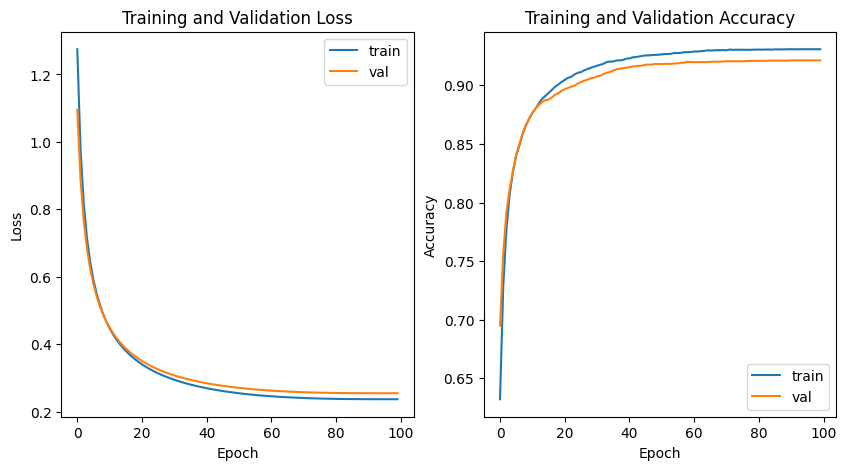

In [83]:
exp_name = "imagenetvit_finetune"
train_and_validate(exp_name, model, train_loader_fe, valid_loader_fe,
                   criterion, optimizer, scheduler, NUM_EPOCHS, val_step=5)

In [87]:
ckpt = torch.load(f'{exp_name}/best.pt')
weights, epoch = ckpt['model'], ckpt['epoch']
print("Loading checkpoint at epoch", epoch)
model.load_state_dict(weights)
test_loss, test_acc = validate(model, test_loader_fe, criterion)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Loading checkpoint at epoch 90
Test Loss: 0.2473834173767655
Test Accuracy: 0.922962962962963


## SSL Weights

In [14]:
path = 'dino/selfsupervised2/best_model.pth'
backbone = torch.load(path, map_location=device).backbone

In [15]:
train_loader_fe = extract_features_from_loader(train_loader, backbone, True)
valid_loader_fe = extract_features_from_loader(val_loader, backbone, False)
test_loader_fe = extract_features_from_loader(test_loader, backbone, False)

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [16]:
num_classes = len(train_ds.dataset.classes)
model = Classifier(384, num_classes).to(device)
# Define the optimizer and scheduler
optimizer = SGD(model.parameters(), lr=LR, weight_decay=WD)
scheduler = CosineAnnealingLR(optimizer, NUM_EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()


Epoch 1
-------------------------------
Train Loss: 2.3283  Train Acc: 0.0476
('Validation Loss: 2.3086 ', 'Validation Acc: 0.0715, ', 'Best: 0.0715 (1)')
Epoch 2
-------------------------------
Train Loss: 2.2893  Train Acc: 0.1082
Epoch 3
-------------------------------
Train Loss: 2.2512  Train Acc: 0.1767
Epoch 4
-------------------------------
Train Loss: 2.2140  Train Acc: 0.2844
Epoch 5
-------------------------------
Train Loss: 2.1776  Train Acc: 0.4114
Epoch 6
-------------------------------
Train Loss: 2.1422  Train Acc: 0.5161
('Validation Loss: 2.1242 ', 'Validation Acc: 0.5424, ', 'Best: 0.5424 (6)')
Epoch 7
-------------------------------
Train Loss: 2.1077  Train Acc: 0.5842
Epoch 8
-------------------------------
Train Loss: 2.0742  Train Acc: 0.6306
Epoch 9
-------------------------------
Train Loss: 2.0415  Train Acc: 0.6643
Epoch 10
-------------------------------
Train Loss: 2.0097  Train Acc: 0.6873
Epoch 11
-------------------------------
Train Loss: 1.9789  Trai

Classifier(
  (model): Linear(in_features=384, out_features=10, bias=True)
)

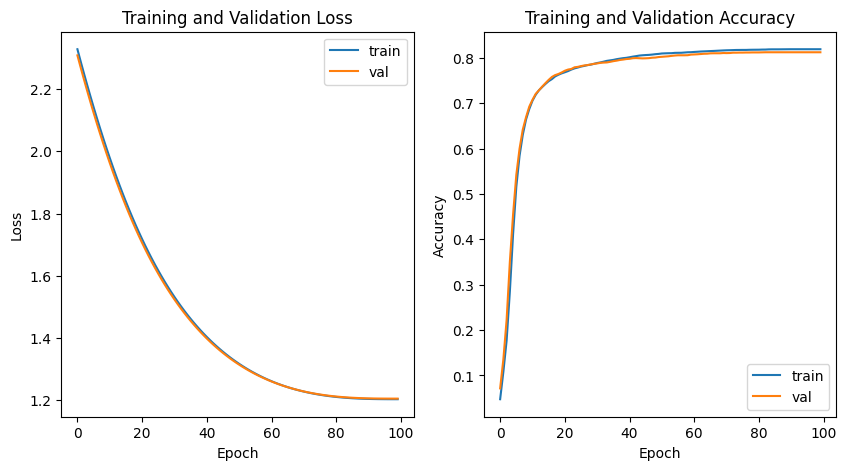

In [17]:
exp_name = "dinovit_finetune"
train_and_validate(exp_name, model, train_loader_fe, valid_loader_fe,
                   criterion, optimizer, scheduler, NUM_EPOCHS, val_step=5)

## Imagenet + SSL

In [14]:
path = 'dino/ssl_imagenet/best_model.pth'
backbone = torch.load(path, map_location=device).backbone

In [15]:
train_loader_fe = extract_features_from_loader(train_loader, backbone, True)
valid_loader_fe = extract_features_from_loader(val_loader, backbone, False)
test_loader_fe = extract_features_from_loader(test_loader, backbone, False)

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train Loss: 1.5074  Train Acc: 0.5357
('Validation Loss: 0.9604 ', 'Validation Acc: 0.7761, ', 'Best: 0.7761 (1)')
Epoch 2
-------------------------------
Train Loss: 0.7346  Train Acc: 0.8450
Epoch 3
-------------------------------
Train Loss: 0.4930  Train Acc: 0.9043
Epoch 4
-------------------------------
Train Loss: 0.3829  Train Acc: 0.9266
Epoch 5
-------------------------------
Train Loss: 0.3203  Train Acc: 0.9371
Epoch 6
-------------------------------
Train Loss: 0.2799  Train Acc: 0.9438
('Validation Loss: 0.2688 ', 'Validation Acc: 0.9465, ', 'Best: 0.9465 (6)')
Epoch 7
-------------------------------
Train Loss: 0.2515  Train Acc: 0.9489
Epoch 8
-------------------------------
Train Loss: 0.2304  Train Acc: 0.9520
Epoch 9
-------------------------------
Train Loss: 0.2140  Train Acc: 0.9539
Epoch 10
-------------------------------
Train Loss: 0.2010  Train Acc: 0.9561
Epoch 11
-------------------------------
Train Loss: 0.1903  Trai

Classifier(
  (model): Linear(in_features=384, out_features=10, bias=True)
)

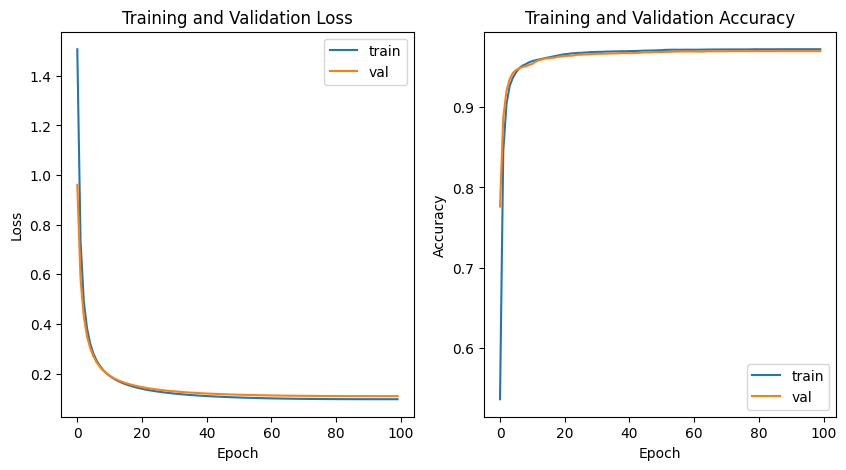

In [16]:
num_classes = len(train_ds.dataset.classes)
model = Classifier(384, num_classes).to(device)
# Define the optimizer and scheduler
optimizer = SGD(model.parameters(), lr=LR, weight_decay=WD)
scheduler = CosineAnnealingLR(optimizer, NUM_EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()

exp_name = "imagenet_dino_vit_FC"
train_and_validate(exp_name, model, train_loader_fe, valid_loader_fe,
                   criterion, optimizer, scheduler, NUM_EPOCHS, val_step=5)
